In [222]:
import mxnet as mx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data = train_data.dropna()

print(train_data.head())
print('===========train data info================')
train_data.info()
print('===========test data info================')
test_data.info()

      x          y
0  24.0  21.549452
1  50.0  47.464463
2  15.0  17.218656
3  38.0  36.586398
4  87.0  87.288984
===========train data info================
<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 699
Data columns (total 2 columns):
x    699 non-null float64
y    699 non-null float64
dtypes: float64(2)
memory usage: 16.4 KB
===========test data info================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
x    300 non-null int64
y    300 non-null float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


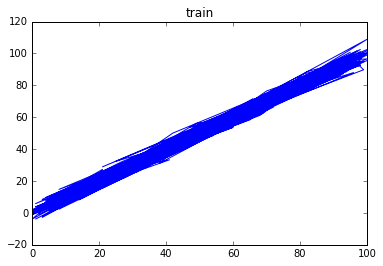

In [223]:
train_X, train_Y, test_X, test_Y = train_data['x'].as_matrix(), train_data['y'].as_matrix(), \
                                    test_data['x'].as_matrix(), test_data['y'].as_matrix()

In [224]:
train_iter = mx.io.NDArrayIter(data=train_X, label=train_Y, batch_size = 1, 
                               shuffle = True, data_name= 'x', label_name='y')
test_iter = mx.io.NDArrayIter(data=test_X, label=test_Y, batch_size = 1, shuffle = False)

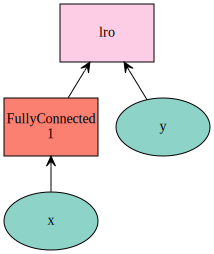

In [225]:
x = mx.sym.var('x')
y = mx.sym.var('y')

yhat = mx.sym.FullyConnected(data=x, num_hidden=1, name = 'fc1')
lro = mx.sym.LinearRegressionOutput(data = yhat, label = y, name = 'lro')
mx.viz.plot_network(lro)
#model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)

In [231]:
model = mx.mod.Module(symbol = lro, data_names = ['x'], label_names = ['y'])
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)

In [232]:
model.init_params(initializer=mx.initializer.Uniform(scale = 0.1), force_init=True)
model.init_optimizer(optimizer='adam', optimizer_params={'wd' : 0.0001, 'learning_rate' : 0.005})
metric = mx.metric.create('mse')
print(model.get_params())

({'fc1_bias': 
[ 0.]
<NDArray 1 @cpu(0)>, 'fc1_weight': 
[[-0.09509452]]
<NDArray 1x1 @cpu(0)>}, {})


In [233]:
epochs = 10
for i in range(epochs):
    train_iter.reset()
    metric.reset()
    for data in train_iter:
        model.forward(data, is_train=True)
        model.update_metric(metric, data.label[0])
        model.backward()
        model.update()
    print('Epoch %d, Training %s' % (i, metric.get()))

Epoch 0, Training ('mse', 647.06109256838147)
Epoch 1, Training ('mse', 8.3493672908575309)
Epoch 2, Training ('mse', 8.3672373148893033)
Epoch 3, Training ('mse', 8.3613483518462939)
Epoch 4, Training ('mse', 8.3620603420270641)
Epoch 5, Training ('mse', 8.3729762773806282)
Epoch 6, Training ('mse', 8.3923311165313876)
Epoch 7, Training ('mse', 8.4135068970807882)
Epoch 8, Training ('mse', 8.4294276510040582)
Epoch 9, Training ('mse', 8.4382391750794383)


In [236]:
metric = mx.metric.MSE()
print(model.score(test_iter, metric))
print(model.get_params())

[('mse', 9.3650079169848084)]
({'fc1_bias': 
[ 0.16647752]
<NDArray 1 @cpu(0)>, 'fc1_weight': 
[[ 1.01053631]]
<NDArray 1x1 @cpu(0)>}, {})


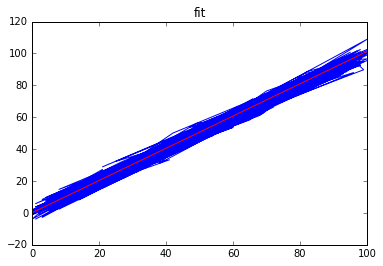

In [249]:
min, max = train_X.min(), train_X.max()
line_x = np.linspace(min, max, 100)
line_y = line_x * model.get_params()[0]['fc1_weight'].asnumpy() + model.get_params()[0]['fc1_bias'].asnumpy()
line_y = line_y[0]

plt.title('fit')
plt.plot(train_X, train_Y, color = 'b')
plt.plot(line_x, line_y, color = 'r')
plt.show()